In [68]:
# %pip install gensim

In [69]:
import pandas as pd
import numpy as np
import os
from gensim.models import Word2Vec

In [70]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Word Embeddings

In [71]:
df_i = pd.read_pickle('/content/drive/MyDrive/BT4222/data/pickles/cleaned_df_i.pkl')
df_c_train = pd.read_pickle('/content/drive/MyDrive/BT4222/data/pickles/df_c_train.pkl')
df_t_train = pd.read_pickle('/content/drive/MyDrive/BT4222/data/pickles/df_t_train.pkl')
df_c_val = pd.read_pickle('/content/drive/MyDrive/BT4222/data/pickles/df_c_val.pkl')
df_t_val = pd.read_pickle('/content/drive/MyDrive/BT4222/data/pickles/df_t_val.pkl')
df_c_test = pd.read_pickle('/content/drive/MyDrive/BT4222/data/pickles/df_c_test.pkl')
df_t_test = pd.read_pickle('/content/drive/MyDrive/BT4222/data/pickles/df_t_test.pkl')
joined_df_train = pd.read_pickle('/content/drive/MyDrive/BT4222/data/pickles/joined_df_t_c_i_train.pkl')

In [72]:
df_i['structured_desc'] = df_i[['prod_name', 'product_type_name', 'product_group_name', 'perceived_colour_value_name', 'colour_group_name']].apply(lambda x: ', '.join(x), axis=1)

In [73]:
tokenized_descriptions = df_i['structured_desc'].apply(lambda x: x.split())
embedding_dim = 100
word2vec_model = Word2Vec(sentences=tokenized_descriptions, vector_size=embedding_dim, window=3, min_count=1, workers=4)

def generate_item_embedding(description, model):
    word_vectors = [model.wv[word] for word in description if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(embedding_dim)
df_i['embedding'] = tokenized_descriptions.apply(lambda x: generate_item_embedding(x, word2vec_model))

In [74]:
df_i.head()

,article_id,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc,structured_desc,embedding
0,108775015,Strap top,253,Vest top,Garment Upper body,Solid,Black,Dark,Black,Ladieswear,Jersey Basic,Jersey top with narrow shoulder straps.,"Strap top, Vest top, Garment Upper body, Dark,...","[-0.2617248, 1.4846323, 1.0968032, -0.6339081,..."
1,108775044,Strap top,253,Vest top,Garment Upper body,Solid,White,Light,White,Ladieswear,Jersey Basic,Jersey top with narrow shoulder straps.,"Strap top, Vest top, Garment Upper body, Light...","[-0.39430368, 1.2593167, 0.8899288, -0.1949674..."
2,108775051,Strap top (1),253,Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Ladieswear,Jersey Basic,Jersey top with narrow shoulder straps.,"Strap top (1), Vest top, Garment Upper body, D...","[-0.39591852, 1.4606887, 1.1969887, 0.24463105..."
3,110065001,OP T-shirt (Idro),306,Bra,Underwear,Solid,Black,Dark,Black,Ladieswear,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...","OP T-shirt (Idro), Bra, Underwear, Dark, Black","[0.6174556, 0.87177, -0.3141322, -0.44915158, ..."
4,110065002,OP T-shirt (Idro),306,Bra,Underwear,Solid,White,Light,White,Ladieswear,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...","OP T-shirt (Idro), Bra, Underwear, Light, White","[0.44699702, 0.58207864, -0.5801135, 0.1152006..."


# Spending Power of Customers

In [75]:
# For Training Set
df_c_train = pd.merge(df_t_train, df_c_train, on='customer_id')
df_c_train = df_c_train.groupby(['customer_id'])['price'].sum().reset_index()
df_c_train.rename(columns={'price': 'total_spent'}, inplace=True)

# For Validation Set
df_c_val = pd.merge(df_t_val, df_c_val, on='customer_id')
df_c_val = df_c_val.groupby(['customer_id'])['price'].sum().reset_index()
df_c_val.rename(columns={'price': 'total_spent'}, inplace=True)

# For Testing Set
df_c_test = pd.merge(df_t_test, df_c_test, on='customer_id')
df_c_test = df_c_test.groupby(['customer_id'])['price'].sum().reset_index()
df_c_test.rename(columns={'price': 'total_spent'}, inplace=True)

In [76]:
quantiles_train = df_c_train['total_spent'].quantile([0, 0.25, 0.75, 1.0])
quantiles_val = df_c_val['total_spent'].quantile([0, 0.25, 0.75, 1.0])
quantiles_test = df_c_test['total_spent'].quantile([0, 0.25, 0.75, 1.0])

def categorize_spending_power(amount, quantiles):
    if amount <= quantiles[0.25]:
        return "Low"
    elif amount <= quantiles[0.75]:
        return "Medium"
    else:
        return "High"

df_c_train['spending_power'] = df_c_train['total_spent'].apply(lambda x: categorize_spending_power(x, quantiles_train))
df_c_val['spending_power'] = df_c_val['total_spent'].apply(lambda x: categorize_spending_power(x, quantiles_val))
df_c_test['spending_power'] = df_c_test['total_spent'].apply(lambda x: categorize_spending_power(x, quantiles_test))

In [77]:
print(df_c_test['spending_power'].value_counts())
print(df_c_val['spending_power'].value_counts())
print(df_c_train['spending_power'].value_counts())

spending_power
Medium    63248
Low       31725
High      31656
Name: count, dtype: int64
spending_power
Medium    49727
Low       24914
High      24847
Name: count, dtype: int64
spending_power
Medium    234880
Low       117452
High      117441
Name: count, dtype: int64


# Preferred Products

In [78]:
merged_df = pd.merge(df_t_train, df_i, on='article_id', how='left')
grouped_df = merged_df.groupby(['customer_id', 'product_group_name']).size().reset_index(name='purchase_count')
top_products = grouped_df.sort_values(by=['customer_id', 'purchase_count'], ascending=[True, False]) \
    .groupby('customer_id').head(1)
top_products_str = top_products.groupby('customer_id')['product_group_name'].apply(lambda x: ', '.join(x)).reset_index()
df_c_train = pd.merge(df_c_train, top_products_str, on='customer_id', how='left')
df_c_train.rename(columns={'product_group_name': 'preferred_products'}, inplace=True)
df_c_train.head()

,customer_id,total_spent,spending_power,preferred_products
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.111814,Medium,Garment Upper body
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.782712,High,Garment Upper body
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.060983,Medium,Underwear
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0.042339,Low,Swimwear
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,0.772729,High,Garment Upper body


In [79]:
merged_df = pd.merge(df_t_val, df_i, on='article_id', how='left')
grouped_df = merged_df.groupby(['customer_id', 'product_group_name']).size().reset_index(name='purchase_count')
top_products = grouped_df.sort_values(by=['customer_id', 'purchase_count'], ascending=[True, False]) \
    .groupby('customer_id').head(1)
top_products_str = top_products.groupby('customer_id')['product_group_name'].apply(lambda x: ', '.join(x)).reset_index()
df_c_val = pd.merge(df_c_val, top_products_str, on='customer_id', how='left')
df_c_val.rename(columns={'product_group_name': 'preferred_products'}, inplace=True)
df_c_val.head()

,customer_id,total_spent,spending_power,preferred_products
0,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.089763,Medium,Swimwear
1,00015c1a121e08bbd2552c15fbbb6e6b19d3bf8f7b6a3d...,0.098271,Medium,Garment Lower body
2,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0.524288,High,Garment Lower body
3,0003867b41fdfb70b1a279010e6514cf0396899eef5750...,0.027441,Low,Garment Upper body
4,000599972ce0544fc72f91810d09e936b23665e7a858a8...,0.135508,Medium,Garment Full body


In [80]:
merged_df = pd.merge(df_t_test, df_i, on='article_id', how='left')
grouped_df = merged_df.groupby(['customer_id', 'product_group_name']).size().reset_index(name='purchase_count')
top_products = grouped_df.sort_values(by=['customer_id', 'purchase_count'], ascending=[True, False]) \
    .groupby('customer_id').head(1)
top_products_str = top_products.groupby('customer_id')['product_group_name'].apply(lambda x: ', '.join(x)).reset_index()
df_c_test = pd.merge(df_c_test, top_products_str, on='customer_id', how='left')
df_c_test.rename(columns={'product_group_name': 'preferred_products'}, inplace=True)
df_c_test.head()

,customer_id,total_spent,spending_power,preferred_products
0,00007d2de826758b65a93dd24ce629ed66842531df6699...,0.399881,High,Garment Lower body
1,0000b2f1829e23b24feec422ef13df3ccedaedc85368e6...,0.387898,High,Underwear
2,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,0.106661,Medium,Underwear
3,0000d6c053fc8f9389d4565051f12402d5774aa4a9d2e5...,0.050814,Medium,Swimwear
4,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,0.130407,Medium,Garment Upper body


# Preferred Color

In [81]:
merged_df = pd.merge(df_t_train, df_i, on='article_id', how='left')
grouped_df = merged_df.groupby(['customer_id', 'colour_group_name']).size().reset_index(name='color_purchase_count')
top_products = grouped_df.sort_values(by=['customer_id', 'color_purchase_count'], ascending=[True, False]) \
    .groupby('customer_id').head(1)
top_products_str = top_products.groupby('customer_id')['colour_group_name'].apply(lambda x: ', '.join(x)).reset_index()
df_c_train = pd.merge(df_c_train, top_products_str, on='customer_id', how='left')
df_c_train.rename(columns={'colour_group_name': 'preferred_colors'}, inplace=True)
df_c_train.head()

,customer_id,total_spent,spending_power,preferred_products,preferred_colors
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.111814,Medium,Garment Upper body,Black
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.782712,High,Garment Upper body,Black
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.060983,Medium,Underwear,Black
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0.042339,Low,Swimwear,Dark Green
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,0.772729,High,Garment Upper body,Black


In [82]:
merged_df = pd.merge(df_t_val, df_i, on='article_id', how='left')
grouped_df = merged_df.groupby(['customer_id', 'colour_group_name']).size().reset_index(name='color_purchase_count')
top_products = grouped_df.sort_values(by=['customer_id', 'color_purchase_count'], ascending=[True, False]) \
    .groupby('customer_id').head(1)
top_products_str = top_products.groupby('customer_id')['colour_group_name'].apply(lambda x: ', '.join(x)).reset_index()
df_c_val = pd.merge(df_c_val, top_products_str, on='customer_id', how='left')
df_c_val.rename(columns={'colour_group_name': 'preferred_colors'}, inplace=True)
df_c_val.head()

,customer_id,total_spent,spending_power,preferred_products,preferred_colors
0,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.089763,Medium,Swimwear,Black
1,00015c1a121e08bbd2552c15fbbb6e6b19d3bf8f7b6a3d...,0.098271,Medium,Garment Lower body,Blue
2,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0.524288,High,Garment Lower body,Black
3,0003867b41fdfb70b1a279010e6514cf0396899eef5750...,0.027441,Low,Garment Upper body,Black
4,000599972ce0544fc72f91810d09e936b23665e7a858a8...,0.135508,Medium,Garment Full body,Black


In [83]:
merged_df = pd.merge(df_t_test, df_i, on='article_id', how='left')
grouped_df = merged_df.groupby(['customer_id', 'colour_group_name']).size().reset_index(name='color_purchase_count')
top_products = grouped_df.sort_values(by=['customer_id', 'color_purchase_count'], ascending=[True, False]) \
    .groupby('customer_id').head(1)
top_products_str = top_products.groupby('customer_id')['colour_group_name'].apply(lambda x: ', '.join(x)).reset_index()
df_c_test = pd.merge(df_c_test, top_products_str, on='customer_id', how='left')
df_c_test.rename(columns={'colour_group_name': 'preferred_colors'}, inplace=True)
df_c_test.head()

,customer_id,total_spent,spending_power,preferred_products,preferred_colors
0,00007d2de826758b65a93dd24ce629ed66842531df6699...,0.399881,High,Garment Lower body,Black
1,0000b2f1829e23b24feec422ef13df3ccedaedc85368e6...,0.387898,High,Underwear,Black
2,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,0.106661,Medium,Underwear,Dark Red
3,0000d6c053fc8f9389d4565051f12402d5774aa4a9d2e5...,0.050814,Medium,Swimwear,Black
4,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,0.130407,Medium,Garment Upper body,Black


# Preferred Perceived Color

In [84]:
merged_df = pd.merge(df_t_train, df_i, on='article_id', how='left')
grouped_df = merged_df.groupby(['customer_id', 'perceived_colour_value_name']).size().reset_index(name='perceived_color_purchase_count')
top_products = grouped_df.sort_values(by=['customer_id', 'perceived_color_purchase_count'], ascending=[True, False]) \
    .groupby('customer_id').head(1)
top_products_str = top_products.groupby('customer_id')['perceived_colour_value_name'].apply(lambda x: ', '.join(x)).reset_index()
df_c_train = pd.merge(df_c_train, top_products_str, on='customer_id', how='left')
df_c_train.rename(columns={'perceived_colour_value_name': 'preferred_perceived_colors'}, inplace=True)
df_c_train.head()

,customer_id,total_spent,spending_power,preferred_products,preferred_colors,preferred_perceived_colors
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.111814,Medium,Garment Upper body,Black,Dark
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.782712,High,Garment Upper body,Black,Dark
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.060983,Medium,Underwear,Black,Dark
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0.042339,Low,Swimwear,Dark Green,Medium Dusty
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,0.772729,High,Garment Upper body,Black,Dark


In [85]:
merged_df = pd.merge(df_t_val, df_i, on='article_id', how='left')
grouped_df = merged_df.groupby(['customer_id', 'perceived_colour_value_name']).size().reset_index(name='perceived_color_purchase_count')
top_products = grouped_df.sort_values(by=['customer_id', 'perceived_color_purchase_count'], ascending=[True, False]) \
    .groupby('customer_id').head(1)
top_products_str = top_products.groupby('customer_id')['perceived_colour_value_name'].apply(lambda x: ', '.join(x)).reset_index()
df_c_val = pd.merge(df_c_val, top_products_str, on='customer_id', how='left')
df_c_val.rename(columns={'perceived_colour_value_name': 'preferred_perceived_colors'}, inplace=True)
df_c_val.head()

,customer_id,total_spent,spending_power,preferred_products,preferred_colors,preferred_perceived_colors
0,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.089763,Medium,Swimwear,Black,Dark
1,00015c1a121e08bbd2552c15fbbb6e6b19d3bf8f7b6a3d...,0.098271,Medium,Garment Lower body,Blue,Light
2,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0.524288,High,Garment Lower body,Black,Dark
3,0003867b41fdfb70b1a279010e6514cf0396899eef5750...,0.027441,Low,Garment Upper body,Black,Dark
4,000599972ce0544fc72f91810d09e936b23665e7a858a8...,0.135508,Medium,Garment Full body,Black,Dark


In [86]:
merged_df = pd.merge(df_t_test, df_i, on='article_id', how='left')
grouped_df = merged_df.groupby(['customer_id', 'perceived_colour_value_name']).size().reset_index(name='perceived_color_purchase_count')
top_products = grouped_df.sort_values(by=['customer_id', 'perceived_color_purchase_count'], ascending=[True, False]) \
    .groupby('customer_id').head(1)
top_products_str = top_products.groupby('customer_id')['perceived_colour_value_name'].apply(lambda x: ', '.join(x)).reset_index()
df_c_test = pd.merge(df_c_test, top_products_str, on='customer_id', how='left')
df_c_test.rename(columns={'perceived_colour_value_name': 'preferred_perceived_colors'}, inplace=True)
df_c_test.head()

,customer_id,total_spent,spending_power,preferred_products,preferred_colors,preferred_perceived_colors
0,00007d2de826758b65a93dd24ce629ed66842531df6699...,0.399881,High,Garment Lower body,Black,Dark
1,0000b2f1829e23b24feec422ef13df3ccedaedc85368e6...,0.387898,High,Underwear,Black,Dark
2,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,0.106661,Medium,Underwear,Dark Red,Bright
3,0000d6c053fc8f9389d4565051f12402d5774aa4a9d2e5...,0.050814,Medium,Swimwear,Black,Dark
4,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,0.130407,Medium,Garment Upper body,Black,Dark


# Merging Preferences into Embeddings

In [87]:
def combine_columns(row):
    return ', '.join(row)
columns_to_combine = ['preferred_products', 'preferred_colors', 'preferred_perceived_colors']

In [88]:
df_c_train['combined_preferences'] = df_c_train[columns_to_combine].apply(combine_columns, axis=1)
df_c_val['combined_preferences'] = df_c_val[columns_to_combine].apply(combine_columns, axis=1)
df_c_test['combined_preferences'] = df_c_test[columns_to_combine].apply(combine_columns, axis=1)

In [89]:
tokenized_descriptions = df_c_train['combined_preferences'].apply(lambda x: x.split())
embedding_dim = 100
word2vec_model = Word2Vec(sentences=tokenized_descriptions, vector_size=embedding_dim, window=3, min_count=1, workers=4)

def generate_item_embedding(description, model):
    word_vectors = [model.wv[word] for word in description if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(embedding_dim)
df_c_train['combined_preferences_embeddings'] = tokenized_descriptions.apply(lambda x: generate_item_embedding(x, word2vec_model))

In [90]:
tokenized_descriptions = df_c_val['combined_preferences'].apply(lambda x: x.split())
embedding_dim = 100
word2vec_model = Word2Vec(sentences=tokenized_descriptions, vector_size=embedding_dim, window=3, min_count=1, workers=4)
df_c_val['combined_preferences_embeddings'] = tokenized_descriptions.apply(lambda x: generate_item_embedding(x, word2vec_model))

In [91]:
tokenized_descriptions = df_c_test['combined_preferences'].apply(lambda x: x.split())
embedding_dim = 100
word2vec_model = Word2Vec(sentences=tokenized_descriptions, vector_size=embedding_dim, window=3, min_count=1, workers=4)
df_c_test['combined_preferences_embeddings'] = tokenized_descriptions.apply(lambda x: generate_item_embedding(x, word2vec_model))

# Average Timelag between Purchase

In [92]:
# to simulate customers who did not make a repurchase within the time span
# since we're dealing with transactions between 3 months, a time of 12 months would be appropriate
no_repurchase_hours = 8760

In [93]:
df_t_train.sort_values(by=['customer_id', 't_dat'], inplace=True)
df_t_train['time_diff'] = df_t_train.groupby('customer_id')['t_dat'].diff()
avg_time_diff = df_t_train.groupby('customer_id')['time_diff'].mean().reset_index()
avg_time_diff.rename(columns={'time_diff': 'avg_time_diff_btw_purchase'}, inplace=True)
df_c_train = pd.merge(df_c_train, avg_time_diff, on='customer_id', how='left')
df_c_train["hours_between_purchases"] = (df_c_train["avg_time_diff_btw_purchase"].dt.total_seconds() / 3600.0).round()
df_c_train["hours_between_purchases"] = df_c_train["hours_between_purchases"].replace(0.00, no_repurchase_hours)

In [94]:
df_t_val.sort_values(by=['customer_id', 't_dat'], inplace=True)
df_t_val['time_diff'] = df_t_val.groupby('customer_id')['t_dat'].diff()
avg_time_diff = df_t_val.groupby('customer_id')['time_diff'].mean().reset_index()
avg_time_diff.rename(columns={'time_diff': 'avg_time_diff_btw_purchase'}, inplace=True)
df_c_val = pd.merge(df_c_val, avg_time_diff, on='customer_id', how='left')
df_c_val["hours_between_purchases"] = (df_c_val["avg_time_diff_btw_purchase"].dt.total_seconds() / 3600.0).round()
df_c_val["hours_between_purchases"] = df_c_val["hours_between_purchases"].replace(0.00, no_repurchase_hours)

In [95]:
df_t_test.sort_values(by=['customer_id', 't_dat'], inplace=True)
df_t_test['time_diff'] = df_t_test.groupby('customer_id')['t_dat'].diff()
avg_time_diff = df_t_test.groupby('customer_id')['time_diff'].mean().reset_index()
avg_time_diff.rename(columns={'time_diff': 'avg_time_diff_btw_purchase'}, inplace=True)
df_c_test = pd.merge(df_c_test, avg_time_diff, on='customer_id', how='left')
df_c_test["hours_between_purchases"] = (df_c_test["avg_time_diff_btw_purchase"].dt.total_seconds() / 3600.0).round()
df_c_test["hours_between_purchases"] = df_c_test["hours_between_purchases"].replace(0.00, no_repurchase_hours)

In [96]:
df_c_train["hours_between_purchases"] = df_c_train["hours_between_purchases"].fillna(no_repurchase_hours)
df_c_val["hours_between_purchases"] = df_c_val["hours_between_purchases"].fillna(no_repurchase_hours)
df_c_test["hours_between_purchases"] = df_c_test["hours_between_purchases"].fillna(no_repurchase_hours)

# User-based Features

In [97]:
transactions_per_user = df_t_train.groupby('customer_id').size().reset_index(name='total_transactions')
avg_max_price_per_user = df_t_train.groupby('customer_id')['price'].agg(['mean', 'max']).reset_index()
avg_max_price_per_user.columns = ['customer_id', 'avg_spent', 'max_spent']
df_c_train = df_c_train.merge(transactions_per_user, on='customer_id', how='left')
df_c_train = df_c_train.merge(avg_max_price_per_user, on='customer_id', how='left')
df_c_train.head()

,customer_id,total_spent,spending_power,preferred_products,preferred_colors,preferred_perceived_colors,combined_preferences,combined_preferences_embeddings,avg_time_diff_btw_purchase,hours_between_purchases,total_transactions,avg_spent,max_spent
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.111814,Medium,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",11 days 12:00:00,276.0,3,0.037271,0.050831
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.782712,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",3 days 10:06:18.947368421,82.0,20,0.039136,0.084729
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.060983,Medium,Underwear,Black,Dark,"Underwear, Black, Dark","[-0.2277323, 0.51116055, 0.020547291, 0.149339...",0 days 00:00:00,8760.0,2,0.030492,0.030492
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0.042339,Low,Swimwear,Dark Green,Medium Dusty,"Swimwear, Dark Green, Medium Dusty","[0.08616607, -0.1816099, 0.25200048, -0.060982...",0 days 00:00:00,8760.0,2,0.021169,0.025407
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,0.772729,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",1 days 21:31:02.068965517,46.0,30,0.025758,0.065881


# Item-based Features

In [98]:
popularity = df_t_train['article_id'].value_counts().reset_index()
popularity.columns = ['article_id', 'popularity']

price_ranges = df_t_train.groupby('article_id')['price'].agg(['min', 'max']).reset_index()
price_ranges['price_range'] = pd.cut(price_ranges['max'], bins=[-float('inf'), price_ranges['max'].quantile(0.25), price_ranges['max'].quantile(0.75), float('inf')], labels=['Low', 'Medium', 'High'])

df_i = pd.merge(df_i, popularity, on='article_id', how='left')
df_i = pd.merge(df_i, price_ranges[['article_id', 'price_range']], on='article_id', how='left')
df_i.head()

,article_id,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc,structured_desc,embedding,popularity,price_range
0,108775015,Strap top,253,Vest top,Garment Upper body,Solid,Black,Dark,Black,Ladieswear,Jersey Basic,Jersey top with narrow shoulder straps.,"Strap top, Vest top, Garment Upper body, Dark,...","[-0.2617248, 1.4846323, 1.0968032, -0.6339081,...",1717.0,Low
1,108775044,Strap top,253,Vest top,Garment Upper body,Solid,White,Light,White,Ladieswear,Jersey Basic,Jersey top with narrow shoulder straps.,"Strap top, Vest top, Garment Upper body, Light...","[-0.39430368, 1.2593167, 0.8899288, -0.1949674...",2553.0,Low
2,108775051,Strap top (1),253,Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Ladieswear,Jersey Basic,Jersey top with narrow shoulder straps.,"Strap top (1), Vest top, Garment Upper body, D...","[-0.39591852, 1.4606887, 1.1969887, 0.24463105...",1.0,Low
3,110065001,OP T-shirt (Idro),306,Bra,Underwear,Solid,Black,Dark,Black,Ladieswear,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...","OP T-shirt (Idro), Bra, Underwear, Dark, Black","[0.6174556, 0.87177, -0.3141322, -0.44915158, ...",111.0,Medium
4,110065002,OP T-shirt (Idro),306,Bra,Underwear,Solid,White,Light,White,Ladieswear,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...","OP T-shirt (Idro), Bra, Underwear, Light, White","[0.44699702, 0.58207864, -0.5801135, 0.1152006...",24.0,Medium


# Trend Score

In [99]:
# Count the number of purchases for each article
article_purchase_count = df_t_train['article_id'].value_counts()

# Calculate the total number of transactions
total_transactions = df_t_train['article_id'].count()

# Calculate the popularity score for each article
article_popularity = article_purchase_count / total_transactions

# Convert the Series to a DataFrame
article_popularity_df = article_popularity.reset_index()
article_popularity_df.columns = ['article_id', 'trend_score']

df_merged = pd.merge(df_t_train, article_popularity_df, on='article_id')

# Group by customer_id and calculate the mean popularity score for each customer
customer_popularity = df_merged.groupby('customer_id')['trend_score'].mean()

# Merge back into df_c_train
df_c_train = df_c_train.merge(customer_popularity, on='customer_id')

# Log Transform of trend_score
df_c_train['log_trend_score'] = df_c_train['trend_score'].apply(lambda x: np.log(x))

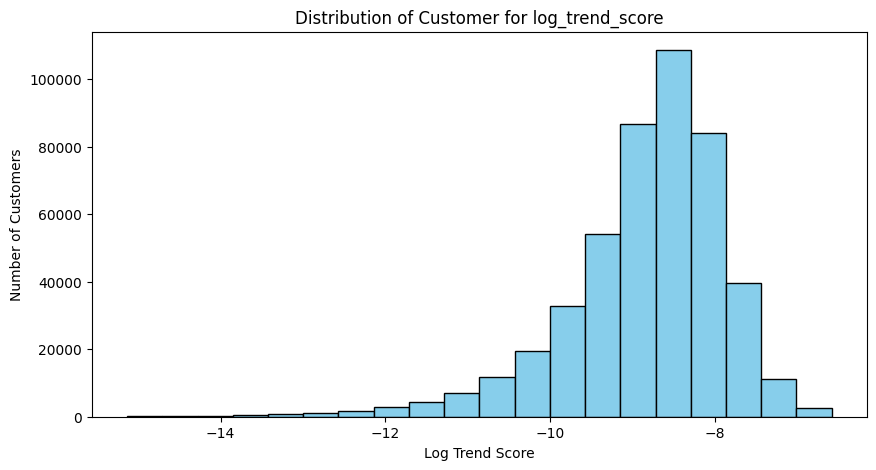

In [100]:
import matplotlib.pyplot as plt

# Assuming customer_popularity is a Series with the index as customer_id and the value as the mean popularity score

# Plot a histogram of the mean popularity scores
plt.figure(figsize=(10, 5))
plt.hist(df_c_train['log_trend_score'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Log Trend Score')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer for log_trend_score')
plt.show()

In [101]:
df_c_train['log_trend_score'].describe()

count    469773.000000
mean         -8.840879
std           0.964710
min         -15.134228
25%          -9.279157
50%          -8.678244
75%          -8.210108
max          -6.586894
Name: log_trend_score, dtype: float64

# Diversity Score

In [103]:
from sklearn.metrics.pairwise import cosine_similarity

df_transactions = pd.merge(df_t_train, df_i, on=['article_id'])

# Group by customer and aggregate the embeddings
grouped = df_transactions.groupby('customer_id')['embedding'].apply(list).reset_index()
diversity_scores = {}
for _, row in grouped.iterrows():
    customer_id = row['customer_id']
    customer_embeddings = row['embedding']
    # Ensure there is more than one item to compare
    if len(customer_embeddings) > 1:
        # Stack embeddings into a 2D array
        embeddings_stack = np.stack(customer_embeddings)
        # Calculate pairwise cosine similarity
        similarity_matrix = cosine_similarity(embeddings_stack)
        # Since the similarity of an item to itself is always 1, we set the diagonal to 0
        np.fill_diagonal(similarity_matrix, 0)
        # Calculate the average similarity for the customer's items (excluding self-similarity)
        avg_similarity = similarity_matrix.sum() / (similarity_matrix.shape[0] * (similarity_matrix.shape[0] - 1))
        diversity_score = 1 - avg_similarity
        diversity_scores[customer_id] = diversity_score
    else:
        # Can't calculate diversity with one item, so set a neutral score or handle accordingly
        diversity_scores[customer_id] = 0.0  # Neutral score

In [120]:
diversity_scores_df = pd.DataFrame.from_dict(diversity_scores, orient='index', columns=['diversity_score'])
df_c_train = pd.merge(df_c_train, diversity_scores_df, left_on='customer_id', right_index=True, how='left')

In [121]:
df_c_train.head()

,customer_id,total_spent,spending_power,preferred_products,preferred_colors,preferred_perceived_colors,combined_preferences,combined_preferences_embeddings,avg_time_diff_btw_purchase,hours_between_purchases,total_transactions,avg_spent,max_spent,trend_score,log_trend_score,diversity_score
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.111814,Medium,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",11 days 12:00:00,276.0,3,0.037271,0.050831,0.000316,-8.060959,0.152843
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.782712,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",3 days 10:06:18.947368421,82.0,20,0.039136,0.084729,0.000197,-8.531776,0.345287
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.060983,Medium,Underwear,Black,Dark,"Underwear, Black, Dark","[-0.2277323, 0.51116055, 0.020547291, 0.149339...",0 days 00:00:00,8760.0,2,0.030492,0.030492,0.000082,-9.407381,0.000947
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0.042339,Low,Swimwear,Dark Green,Medium Dusty,"Swimwear, Dark Green, Medium Dusty","[0.08616607, -0.1816099, 0.25200048, -0.060982...",0 days 00:00:00,8760.0,2,0.021169,0.025407,0.000269,-8.219498,0.071792
4,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,0.772729,High,Garment Upper body,Black,Dark,"Garment Upper body, Black, Dark","[-0.16557673, 0.12581567, 0.18150374, -0.09454...",1 days 21:31:02.068965517,46.0,30,0.025758,0.065881,0.000111,-9.109974,0.155789


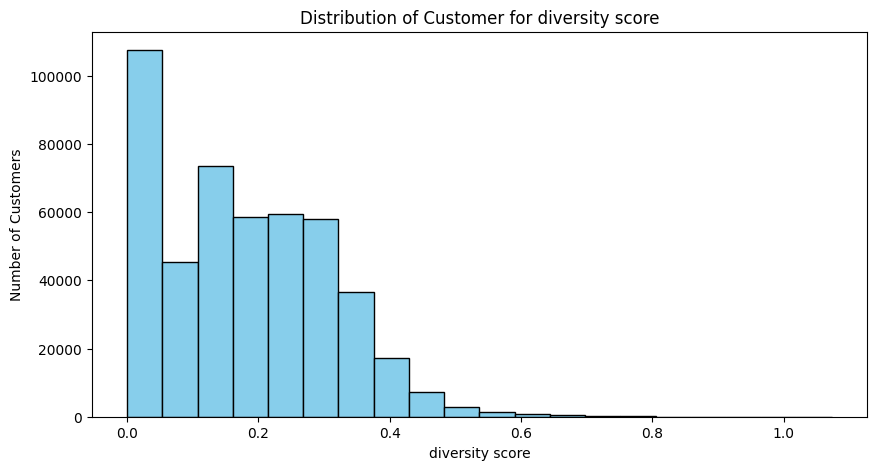

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df_c_train['diversity_score'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('diversity score')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer for diversity score')
plt.show()

# Converting Dataframes to Pickle Files

In [ ]:
df_t_train.to_pickle(os.path.join(os.getcwd(),'data','df_t_train_fe.pkl'))
df_t_val.to_pickle(os.path.join(os.getcwd(),'data', 'df_t_val_fe.pkl'))
df_t_test.to_pickle(os.path.join(os.getcwd(),'data', 'df_t_test_fe.pkl'))
df_c_train.to_pickle(os.path.join(os.getcwd(),'data', 'df_c_train_fe.pkl'))
df_c_val.to_pickle(os.path.join(os.getcwd(),'data', 'df_c_val_fe.pkl'))
df_c_test.to_pickle(os.path.join(os.getcwd(),'data', 'df_c_test_fe.pkl'))
df_i.to_pickle(os.path.join(os.getcwd(),'data', 'df_i_fe.pkl'))

# Style Dictionary

In [ ]:
#imports
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from string import punctuation

In [ ]:
#Create Style Dictionary

#get all description tokens
all_tokens = []
for description in df_i['detail_desc']:
    tokens = word_tokenize(description)
    all_tokens.extend(tokens)

all_tokens_lower = [word.lower() for word in all_tokens]

#define common words (used as filter)
common_words = set(stopwords.words('english') +
                   list(punctuation) +
                   ['the', 'and', 'is', 'are', 'of', 'in', 'on', 'with', 'for', 'to', 'at', 'from', 'as', 'by', 'or'])

#define colour, product and garment (used as filter)
colour_tokens = []
for colour in df_i['colour_group_name']:
    tokens = word_tokenize(colour)
    colour_tokens.extend(tokens)

product_tokens = []
for prod in df_i['product_group_name']:
    tokens = word_tokenize(prod)
    product_tokens.extend(tokens)

garment_tokens = []
for garm in df_i['garment_group_name']:
    tokens = word_tokenize(garm)
    garment_tokens.extend(tokens)

fashion_words = set(colour_tokens + product_tokens + garment_tokens)

#filter common and fashion words
for_filtering = common_words.union(fashion_words)
filtered_tokens = [word for word in all_tokens_lower if word.lower() not in for_filtering]

#output style dictionary
word_counts = Counter(filtered_tokens)
style_dictionary = dict(word_counts)
style_dictionary_top20 = dict(word_counts.most_common(20))

print("Fashion Style Dictionary:")
print(style_dictionary_top20)

In [ ]:
#Individual Article Style Assignment

#create new column to store style
df_i['article_style'] = ''

#iterate through each row in df_i
for index, row in df_i.iterrows():
    #tokenize description
    desc_tokens = word_tokenize(row['detail_desc'])
    desc_tokens_lower = [word.lower() for word in desc_tokens]

    #filter out common words and fashion_words
    filtered_desc_tokens = [word for word in desc_tokens_lower if word.lower() not in for_filtering]

    #initialise variables for comparing filtered tokens
    style = ''
    max_occ = 0

    #compare occurences of filtered tokens, set max occurence as style
    for i in range(len(filtered_desc_tokens)):
        curr_token = filtered_desc_tokens[i]
        curr_occ = style_dictionary[curr_token]
        if curr_occ > max_occ:
            style = curr_token

    #set style in df_i
    df_i.at[index, 'article_style'] = style

In [ ]:
#check styles
# print('Values in article_style:')
# print(df_i['article_style'])
# print(df_i)